


# **1. Import Libraries**






In [ ]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Input,Dropout, Dense,GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential,Model
from tensorflow.keras.layers import Input, UpSampling2D
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import datetime
import pandas as pd
import cv2
import os
import io

# **2. Load Data**

**2-1. Connect To Google Drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**2-2. Unzip Dataset**

In [ ]:
# from zipfile import ZipFile

# with ZipFile('drive/MyDrive/brain_dataset.zip', 'r') as zipOb:
#   zipOb.extractall('drive/MyDrive/brain_tumor_dataset')

**2-3. Loading and Resizing**

In [ ]:
labels = []

X_train = []
y_train = []
X_test = []
y_test = []


trainPath = 'drive/MyDrive/brain_tumor_dataset'+'/Training/'
testPath = 'drive/MyDrive/brain_tumor_dataset'+'/Testing/'


for folder in os.listdir(trainPath):
    labels.append(folder)


for i in labels:
    labelPath = os.path.join(trainPath,i)
    for j in os.listdir(labelPath):
        img = cv2.imread(os.path.join(labelPath,j))
        img = cv2.resize(img,(128, 128))
        X_train.append(img)
        y_train.append(i)


for i in labels:
    labelPath = os.path.join(testPath,i)
    for j in os.listdir(labelPath):
        img = cv2.imread(os.path.join(labelPath,j))
        img = cv2.resize(img,(128, 128))
        X_test.append(img)
        y_test.append(i)

**2-4. Converting Lists to NumPy Arrays and Rescaling Pixel Values**

In [ ]:
# python list to numpy array
X_train = np.array(X_train)
y_train = np.array(y_train)

X_test = np.array(X_test)
y_test = np.array(y_test)

# rescaling
X_train=X_train/255.0
X_test=X_test/255.0

**2-5. Checking Shape of NumPy Arrays**

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(5712, 128, 128, 3) (5712,)
(1311, 128, 128, 3) (1311,)


**2-6. Visualizing Random Samples from the Dataset**

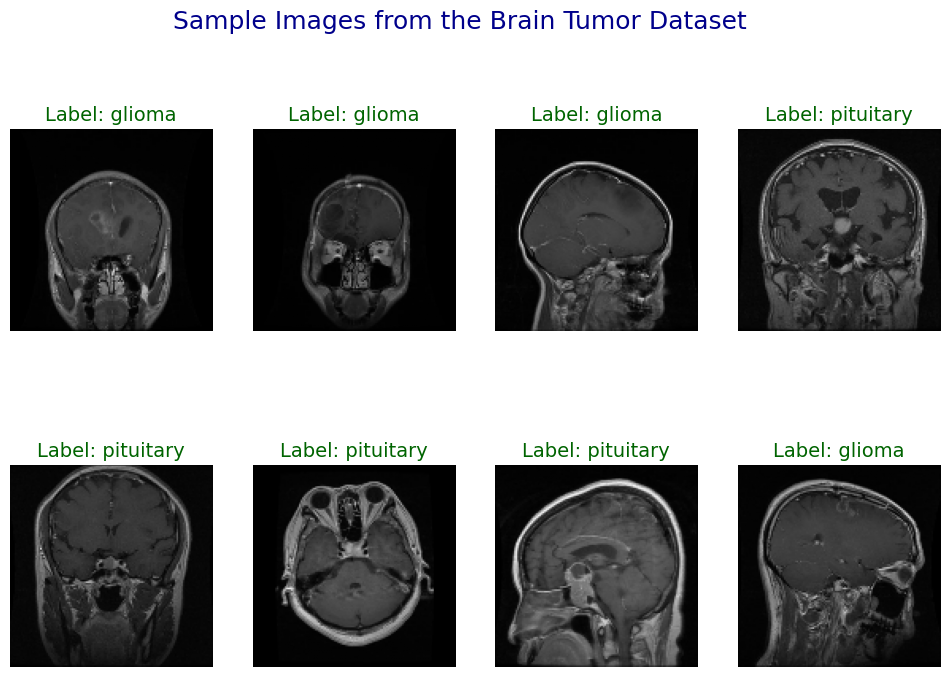

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Display sample images from the training set
fig, axes = plt.subplots(2, 4, figsize=(12, 8))
fig.suptitle('Sample Images from the Brain Tumor Dataset', fontsize=18, color='darkblue')

for i in range(2):
    for j in range(4):
        random_index = np.random.randint(0, len(X_train))
        ax = axes[i, j]
        ax.imshow(X_train[random_index], cmap='plasma')  # Use a colormap for better visualization
        ax.set_title(f'Label: {y_train[random_index]}', fontsize=14, color='darkgreen')
        ax.axis('off')
plt.show()


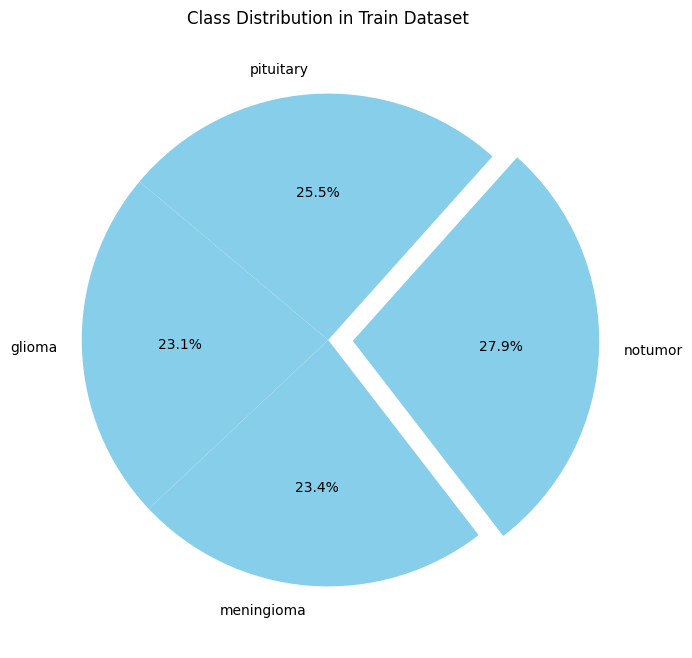

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_class_distribution_pie(labels, dataset_name):
    unique_labels, label_counts = np.unique(labels, return_counts=True)

    plt.figure(figsize=(8, 8))
    colors = ['skyblue'] * len(unique_labels)  # Set all parts to the same color

    # Find the index of the largest slice
    explode = [0.1 if count == max(label_counts) else 0 for count in label_counts]

    # Set the border width for each wedge
    wedgeprops = {'linewidth': 2}

    plt.pie(label_counts, labels=unique_labels, autopct='%1.1f%%', startangle=140, colors=colors, explode=explode, wedgeprops=wedgeprops)
    plt.title(f'Class Distribution in {dataset_name} Dataset')
    plt.show()

# Example usage
# Replace the placeholder below with your actual dataset and labels
plot_class_distribution_pie(y_train, "Train")


# **3. Data Preparation Pipeline: One-Hot Encoding, Splitting and Data Generation**

**3-1. One-Hot Encoding Labels**

In [ ]:
# One Hot Encoding
y_train_new = []
for i in y_train:
  y_train_new.append(labels.index(i))
y_train = y_train_new
y_train = tf.keras.utils.to_categorical(y_train)

y_test_new = []
for i in y_test:
  y_test_new.append(labels.index(i))
y_test = y_test_new
y_test = tf.keras.utils.to_categorical(y_test)

**3-2. Shuffling and Splitting Data**

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

**3-3. Checking Shapes of Training, Testing, and Validation Sets**

In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(4855, 128, 128, 3) (4855, 4)
(1311, 128, 128, 3) (1311, 4)
(857, 128, 128, 3) (857, 4)


# **4. Data Augmentation**

In [ ]:
import cv2
import numpy as np

# Assuming X_train, X_test, and X_val are your RGB image datasets with shape (num_samples, height, width, channels)

def rgb_to_gray(images):
    gray_images = np.zeros((images.shape[0], images.shape[1], images.shape[2], 1), dtype=np.uint8)

    for i in range(images.shape[0]):
        # Convert to 8-bit precision before converting to grayscale
        temp_image = (images[i] * 255).astype(np.uint8)
        gray = cv2.cvtColor(temp_image, cv2.COLOR_RGB2GRAY)
        gray_images[i, ..., 0] = gray.reshape((images.shape[1], images.shape[2]))

    return gray_images

# Convert RGB to Grayscale for train, test, and validation sets
X_train = rgb_to_gray(X_train)
X_test = rgb_to_gray(X_test)
X_val = rgb_to_gray(X_val)

# Display the new shapes
print("GrayScale Shapes:")
print("X_train:", X_train.shape)
print("X_test:", X_test.shape)
print("X_val:", X_val.shape)


GrayScale Shapes:
X_train: (4855, 128, 128, 1)
X_test: (1311, 128, 128, 1)
X_val: (857, 128, 128, 1)


In [ ]:
X_train = X_train.astype('float32')/255.0
X_val = X_val.astype('float32')/255.0
X_test = X_test.astype('float32')/255.0
X_train = X_train.reshape((len(X_train), np.prod(X_train.shape[1:])))
X_val = X_val.reshape((len(X_val), np.prod(X_val.shape[1:])))
X_test = X_test.reshape((len(X_test), np.prod(X_test.shape[1:])))
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(4855, 16384)
(857, 16384)
(1311, 16384)


In [ ]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)
print(X_val.shape, y_val.shape)

(4855, 16384) (4855, 4)
(1311, 16384) (1311, 4)
(857, 16384) (857, 4)


In [ ]:
import keras
from keras import layers

# This is the size of our encoded representations
encoding_dim = 64  

# This is our input image
input_img = keras.Input(shape=(16384,))
# "encoded" is the encoded representation of the input
encoded = Dense(256, activation='relu')(input_img)
encoded = BatchNormalization()(encoded)  # Add Batch Normalization
encoded = layers.Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(256, activation='relu')(encoded)
decoded = BatchNormalization()(decoded)  # Add Batch Normalization
decoded = layers.Dense(16384, activation='sigmoid')(encoded)

# This model maps an input to its reconstruction
autoencoder = keras.Model(input_img, decoded)

In [ ]:
# This model maps an input to its encoded representation
encoder = keras.Model(input_img, encoded)

In [ ]:

encoded_input = keras.Input(shape=(encoding_dim,))
# Retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# Create the decoder model
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

In [ ]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
autoencoder.compile(optimizer=optimizer, loss='mean_squared_error')

In [ ]:
autoencoder.fit(X_train, X_train,
                epochs=60,
                batch_size=256,
                validation_data=(X_val, X_val))

Epoch 1/60
19/19 [==============================] - 3s 43ms/step - loss: 0.0681 - val_loss: 0.0386
Epoch 2/60
19/19 [==============================] - 0s 25ms/step - loss: 0.0374 - val_loss: 0.0330
Epoch 3/60
19/19 [==============================] - 0s 25ms/step - loss: 0.0326 - val_loss: 0.0304
Epoch 4/60
19/19 [==============================] - 0s 26ms/step - loss: 0.0299 - val_loss: 0.0280
Epoch 5/60
19/19 [==============================] - 0s 25ms/step - loss: 0.0276 - val_loss: 0.0261
Epoch 6/60
19/19 [==============================] - 0s 25ms/step - loss: 0.0261 - val_loss: 0.0248
Epoch 7/60
19/19 [==============================] - 0s 26ms/step - loss: 0.0248 - val_loss: 0.0241
Epoch 8/60
19/19 [==============================] - 0s 25ms/step - loss: 0.0239 - val_loss: 0.0238
Epoch 9/60
19/19 [==============================] - 0s 26ms/step - loss: 0.0232 - val_loss: 0.0231
Epoch 10/60
19/19 [==============================] - 0s 25ms/step - loss: 0.0227 - val_loss: 0.0228
Epoch 11/

In [ ]:
# Encode and decode some digits
# Note that we take them from the *test* set
encoded_imgs = encoder.predict(X_test)
decoded_imgs = decoder.predict(encoded_imgs)

41/41 [==============================] - 0s 2ms/step


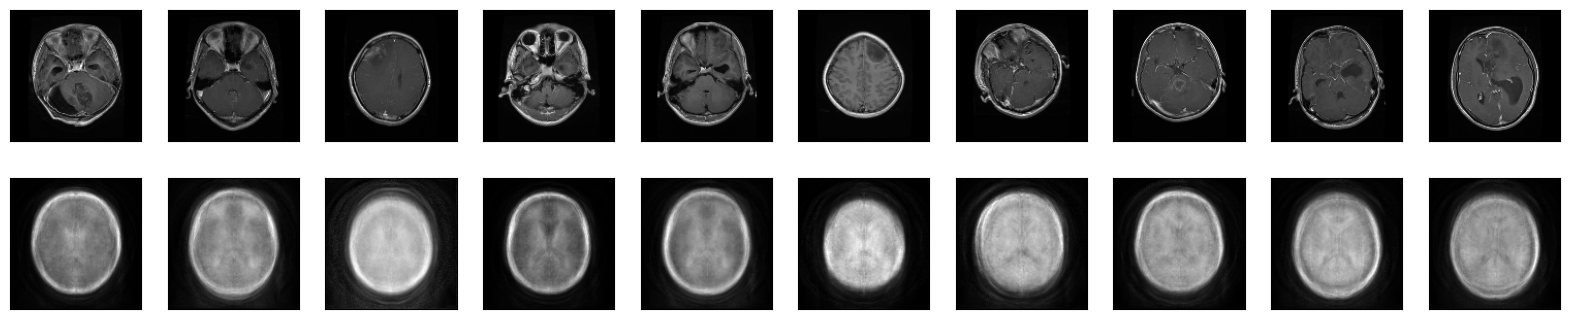

In [ ]:
# Display original images
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(X_test[i].reshape(128, 128))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

# Display reconstructed images
for i in range(n):
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(128, 128))  # Assuming your decoded images have the same size
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()


In [ ]:
print(decoded_imgs.shape)
print(decoded_imgs[1].shape)

(1311, 16384)
(16384,)


In [ ]:
# Assuming decoded_imgs is your array with shape (1311, 16384)
decoded_imgs_reshaped = np.reshape(decoded_imgs, (decoded_imgs.shape[0], 128, 128, 1))

In [ ]:
decoded_imgs_reshaped = np.array(decoded_imgs_reshaped)
print(decoded_imgs_reshaped.shape)
print(decoded_imgs_reshaped[1].shape)

(1311, 128, 128, 1)
(128, 128, 1)


In [ ]:
# Assuming decoded_imgs is your array with shape (1311, 16384)
X_train = np.reshape(X_train, (X_train.shape[0], 128, 128, 1))
X_test = np.reshape(X_test, (X_test.shape[0], 128, 128, 1))
X_val = np.reshape(X_val, (X_val.shape[0], 128, 128, 1))

In [ ]:
# Assuming X_train is your original data with shape (num_samples, height, width, channels)
# If your data is grayscale, add a channel dimension
if len(X_train.shape) == 3:
    X_train = np.expand_dims(X_train, axis=-1)

# Create an ImageDataGenerator for augmentation
train_datagen_augmented = ImageDataGenerator(
    fill_mode="nearest",
    zoom_range=0.2,
    shear_range=0.2,
    horizontal_flip=True,
    validation_split=0.1
)

# Flow from the augmented data generator
train_generator_augmented = train_datagen_augmented.flow(X_train, y_train, batch_size=len(X_train), shuffle=False)

# Get the augmented data
X_train_augmented, y_train_augmented = train_generator_augmented.next()

# Concatenate augmented data with the original data
X_train_combined = np.concatenate((X_train, X_train_augmented))
y_train_combined = np.concatenate((y_train, y_train_augmented))


# **5. Network Architecture**

**5-1. Convolutional Neural Network Architecture**

In [ ]:
model = Sequential()

#layer 1
model.add(Conv2D(filters=64, kernel_size=(3,3), input_shape=(128, 128, 1), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#layer 2
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#layer 2
model.add(Conv2D(filters=256, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#layer 2
model.add(Conv2D(filters=512, kernel_size=(3,3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


#layer 3
model.add(Conv2D(filters=1024, kernel_size=(3,3), padding='same'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

# model.add(Dense(units= 1024, activation='relu'))
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=4, activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 128, 128, 64)      640       
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 64, 64, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 256)       147712    
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 256)       0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 256)       590080    
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 16, 16, 256)      

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler

# Define the custom learning rate schedule
def lr_schedule(epoch):
    lr = 0.001
    if epoch > 20:
        lr *= 0.5
    elif epoch > 15:
        lr *= 0.7
    return lr

# Create an instance of the LearningRateScheduler callback
scheduler = LearningRateScheduler(lr_schedule)



optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy'])


# **6. Training**

**6-1. Early Stopping**

In [ ]:
# from tensorflow.keras.callbacks import EarlyStopping
# # Define early stopping callback
# early_stopping = EarlyStopping(monitor='val_accuracy', patience=3, mode='max')

**6-2. Training Convolutional Neural Network**

In [ ]:
# history = model.fit(train_datagenerator, epochs =20, batch_size=32, validation_data=(X_val,y_val), callbacks=[early_stopping])
# history = model.fit(X_train, y_train, epochs =20, batch_size=32, validation_data=(X_val,y_val), callbacks=[early_stopping])
history = model.fit(X_train_combined, y_train_combined, epochs =20, batch_size=32, validation_data=(X_val,y_val))

Epoch 1/20
304/304 [==============================] - 38s 93ms/step - loss: 0.7889 - accuracy: 0.6695 - val_loss: 0.5694 - val_accuracy: 0.7620
Epoch 2/20
304/304 [==============================] - 24s 78ms/step - loss: 0.4242 - accuracy: 0.8371 - val_loss: 0.3167 - val_accuracy: 0.8658
Epoch 3/20
304/304 [==============================] - 24s 78ms/step - loss: 0.2681 - accuracy: 0.9010 - val_loss: 0.2984 - val_accuracy: 0.8973
Epoch 4/20
304/304 [==============================] - 24s 79ms/step - loss: 0.1751 - accuracy: 0.9366 - val_loss: 0.1638 - val_accuracy: 0.9417
Epoch 5/20
304/304 [==============================] - 24s 78ms/step - loss: 0.1398 - accuracy: 0.9499 - val_loss: 0.1910 - val_accuracy: 0.9463
Epoch 6/20
304/304 [==============================] - 24s 78ms/step - loss: 0.0886 - accuracy: 0.9688 - val_loss: 0.1979 - val_accuracy: 0.9265
Epoch 7/20
304/304 [==============================] - 24s 78ms/step - loss: 0.0724 - accuracy: 0.9749 - val_loss: 0.2235 - val_accuracy:

# **7. Model Predictions**

**7-1. Predictions and Ground Truth Label Processing**

In [ ]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)
y_test_new = np.argmax(y_test,axis=1)

41/41 [==============================] - 2s 56ms/step


**7-2. Calculating Accuracy of CNN Model**

In [ ]:
accuracy = np.sum(pred==y_test_new)/len(pred)
print(accuracy)

0.9649122807017544


# **8. Visualizing**

**8-1. Visualizing CNN Model Performance: Accuracy and Loss Over Epochs**

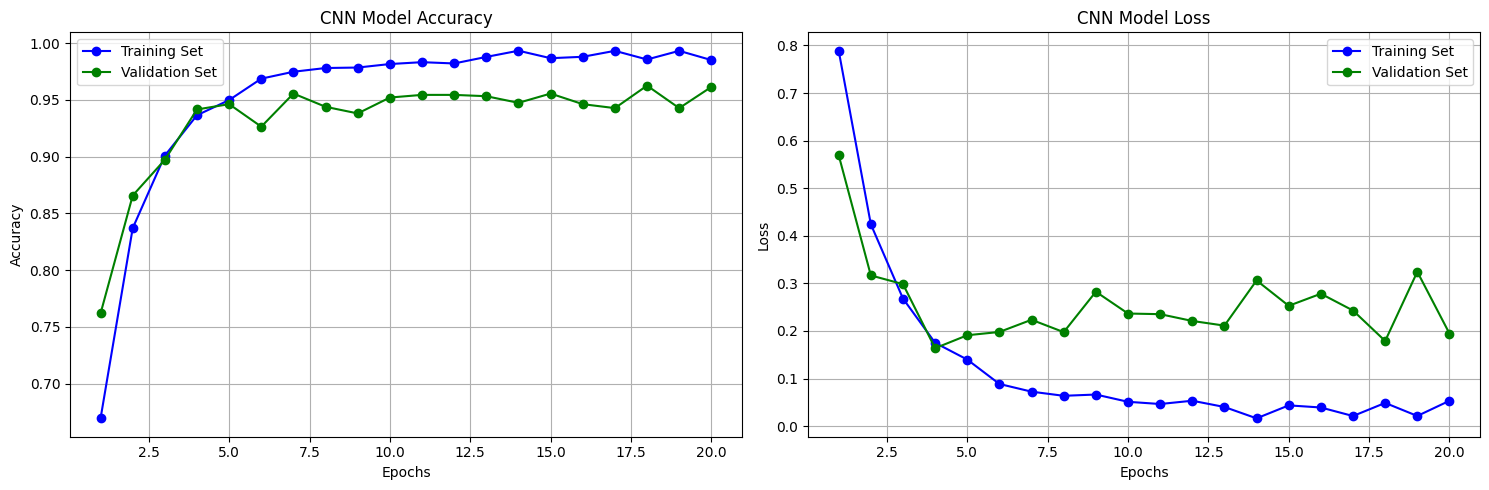

In [ ]:
# Plot model performance with enhanced aesthetics
acc = history.history['accuracy']
loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15, 5))

# Plot Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Set', marker='o', linestyle='-', color='b')
plt.plot(epochs_range, val_acc, label='Validation Set', marker='o', linestyle='-', color='g')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('CNN Model Accuracy')
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Set', marker='o', linestyle='-', color='b')
plt.plot(epochs_range, val_loss, label='Validation Set', marker='o', linestyle='-', color='g')
plt.legend(loc='best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('CNN Model Loss')
plt.grid(True)

plt.tight_layout()
plt.show()

**8-2. confusion Matrix**

41/41 [==============================] - 1s 17ms/step


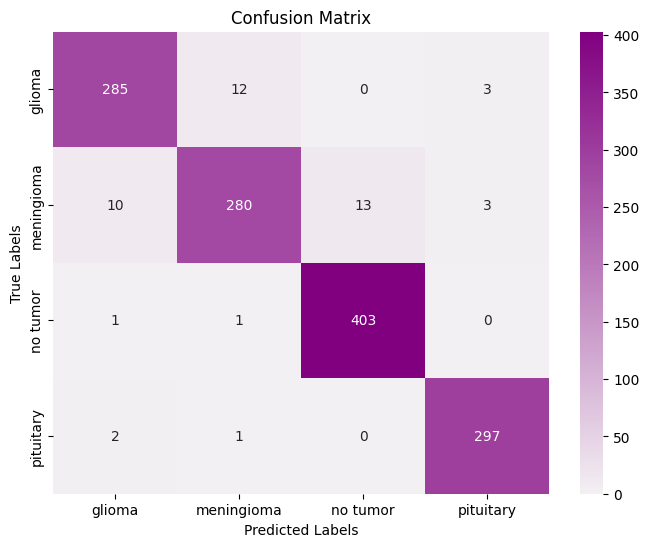

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'model' is your trained model and X_test, y_test are your test data
y_pred = np.argmax(model.predict(X_test), axis=1)

# Get the true labels
y_true = np.argmax(y_test, axis=1)

# Generate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Define a colormap
cmap = sns.light_palette("purple", as_cmap=True)

# Plot the confusion matrix with color
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap=cmap,
            xticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'],
            yticklabels=['glioma', 'meningioma', 'no tumor', 'pituitary'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
